# Introduccion a pytorch
En este ejercicio haremos uso de la librería de pytorch para aprendizaje profundo. Para iniciar, ve a la [página de Pytorch](https://pytorch.org/get-started/locally/) e instala la versión que corresponda a tu sistema operativo. Recuerda activar tu ambiente antes de instarlo. La instalación tomará unos minutos.

```
conda activate sistemas_inteligentes
pip3 install torch torchvision torchaudio
```

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torch.nn  as nn
import torch.nn.functional as F
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
import os
import json

## Datos originales
Aquí cargamos los datos originales y observamos los valores de las primeras 3 columnas. En este ejercio utilizaremos el conjunto de datos del problema de las casas que utilizamos para entrenar regresión lineal.

In [2]:
def read_data(data_dir, file):
    path = os.path.join(data_dir, file)
    df = pd.read_csv(path)
    return df

# Leer los datasets
data_dir = "./data"
data = read_data(data_dir, "train.csv")
full_dataset, labels = data.iloc[:, 1:-1], data.iloc[:, -1]
print(full_dataset.head(3))
print(f"Conjunto de datos de dimensinalidad:{full_dataset.shape}, etiquetas {labels.shape}")

   MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape   
0          60       RL         65.0     8450   Pave   NaN      Reg  \
1          20       RL         80.0     9600   Pave   NaN      Reg   
2          60       RL         68.0    11250   Pave   NaN      IR1   

  LandContour Utilities LotConfig  ... ScreenPorch PoolArea PoolQC Fence   
0         Lvl    AllPub    Inside  ...           0        0    NaN   NaN  \
1         Lvl    AllPub       FR2  ...           0        0    NaN   NaN   
2         Lvl    AllPub    Inside  ...           0        0    NaN   NaN   

  MiscFeature MiscVal  MoSold  YrSold  SaleType  SaleCondition  
0         NaN       0       2    2008        WD         Normal  
1         NaN       0       5    2007        WD         Normal  
2         NaN       0       9    2008        WD         Normal  

[3 rows x 79 columns]
Conjunto de datos de dimensinalidad:(1460, 79), etiquetas (1460,)


## Data split
Para poder simular un conjunto de prueba y evaluar nuestro modelo, separamos los datos en entrenamiento y validación.

In [3]:
from sklearn.model_selection import train_test_split
train_data, val_data, train_labels, val_labels = train_test_split(full_dataset,
                                                                  labels,
                                                                  test_size = 0.2,
                                                                  random_state = 0)
print(f"Entrenamiento de dimensinalidad:{train_data.shape}, etiquetas {train_labels.shape}")
print(f"Validación de dimensinalidad:{val_data.shape}, etiquetas {val_labels.shape}")

Entrenamiento de dimensinalidad:(1168, 79), etiquetas (1168,)
Validación de dimensinalidad:(292, 79), etiquetas (292,)


## Preprocesamiento de datos

Abre el archivo .csv dentro de la carpeta de data y observa como están dados los datos. Notarás que algunas columnas tienen valores string en lugar de números, algunas filas tienen valores NaN, algunos valores están vacios y demás.

La mayoría de los datasets reales son como el que usamos en este ejercicio, sin embargo para poder aprender de ellos necesitamos deshacernos de las tres condiciones anterirmente mencionadas. Por lo tanto, antes de poder aplicar cualquier método de aprendizaje primero deberémos:
1. Eliminar cualquier celda con valores NaN
2. Remplazar las entradas categóricas (string) por numéricas

Para tratar con los NaN, vamos a asignarle un número distintivo. En este caso hemos elegido el número "-1". Entonces, para toda celda cuyo valor sea desconocido, simplemente le asignaremos el valor de "-1".

Para tratar con el segundo caso, crearemos un "mapa" de strings a enteros. Por ejemplo si para cada casa se indica el material de construcción como "block" y "ladrillo" crearemos un mapa que nos de un número entero para cada tipo de material. Por ejemplo considera el mapeo:
```
material = {"block": 1,
            "ladrillo": 2}
```
En este caso si en alguna fila la columna de "material" originalmente fuera "block" entonces en los datos después del pre procesamiento, ahora diría "1". Para ello utilizaremos la utilería de sklearn [`OrdinalEncoder`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OrdinalEncoder.html). Recuerda que es importante aplicar el mismo preprocesamiento a TODOS los datos (incluyendo los de prueba), y que los datos que utilizamos para afinar este preprocesamiento son los de entrenamiento.

In [4]:
def apply_preprocessing(dataset, feat_encoder, columns):
    '''
        args:
        - dataset (pd.DataFrame): Conjunto de datos
        - feat_encoder (OrdinalEncoder): instancia de codificador para las variables de entrada ajustado con datos de entrenamiento
        returns:
        - transformed_dataset (np.array): dataset transformado
    '''
    # Reemplazar valores categóricos por numéricos
    transformed_dataset = dataset.copy()
    transformed_dataset[columns] = feat_encoder.transform(dataset[columns])
    # Reemplazar NaN con -1
    transformed_dataset[np.isnan(transformed_dataset)] = -1
    return transformed_dataset.to_numpy()

In [5]:
from sklearn.preprocessing import OrdinalEncoder

# Definimos un codificador para los atributos de entrada
# Especificamos que para valores desconocidos tome -1
# solo usamos entrenamiento apra definir el codificador
obj_cols = (train_data.dtypes == 'object')
obj_cols = list(obj_cols[obj_cols].index)
feat_encoder= OrdinalEncoder(handle_unknown='use_encoded_value',
                             unknown_value=-1)
feat_encoder.fit(train_data[obj_cols])

# Aplicamos el mismo preprocesamiento a todos los datasets
train_data = apply_preprocessing(train_data, feat_encoder, obj_cols)
val_data = apply_preprocessing(val_data, feat_encoder, obj_cols)

# Transformar las etiquetas a arreglos de numpy
if not isinstance(train_labels, np.ndarray):
    train_labels = train_labels.to_numpy()
    val_labels = val_labels.to_numpy()
print("Entrenamiento shapes", train_data.shape, train_labels.shape, type(train_data))
print("Validacion shapes", val_data.shape, val_labels.shape)

Entrenamiento shapes (1168, 79) (1168,) <class 'numpy.ndarray'>
Validacion shapes (292, 79) (292,)


Y aplicamos el mismo pre procesamiento a los datos de prueba

In [6]:
# Cargamos los datos de prueba y aplicamos el mismo proceso
# Solo que en este caso no hay etiquetas
test_data = read_data(data_dir, "test.csv")
# TODO: aplica el preprocesamiento de datos al conjunto de prueba
test_data = apply_preprocessing(test_data, feat_encoder, obj_cols)
print("Prueba shapes", test_data.shape)

Prueba shapes (1459, 80)


# Datos preprocesados
¿Recuerdas los datos originales? Después del pre procesamiento, esta es la información que recibiría el modelo durante entrenamiento

In [7]:
print("Datos después de limpiarlos")
print(train_data[:3])

Datos después de limpiarlos
[[ 2.0000e+01  3.0000e+00  9.0000e+01  1.1694e+04  1.0000e+00 -1.0000e+00
   3.0000e+00  3.0000e+00  0.0000e+00  4.0000e+00  0.0000e+00  1.6000e+01
   2.0000e+00  2.0000e+00  0.0000e+00  2.0000e+00  9.0000e+00  5.0000e+00
   2.0070e+03  2.0070e+03  3.0000e+00  0.0000e+00  5.0000e+00  5.0000e+00
   1.0000e+00  4.5200e+02  0.0000e+00  4.0000e+00  2.0000e+00  0.0000e+00
   3.0000e+00  0.0000e+00  2.0000e+00  4.8000e+01  5.0000e+00  0.0000e+00
   1.7740e+03  1.8220e+03  1.0000e+00  0.0000e+00  1.0000e+00  4.0000e+00
   1.8280e+03  0.0000e+00  0.0000e+00  1.8280e+03  0.0000e+00  0.0000e+00
   2.0000e+00  0.0000e+00  3.0000e+00  1.0000e+00  2.0000e+00  9.0000e+00
   5.0000e+00  1.0000e+00  2.0000e+00  1.0000e+00  2.0070e+03  2.0000e+00
   3.0000e+00  7.7400e+02  4.0000e+00  4.0000e+00  2.0000e+00  0.0000e+00
   1.0800e+02  0.0000e+00  0.0000e+00  2.6000e+02  0.0000e+00 -1.0000e+00
  -1.0000e+00 -1.0000e+00  0.0000e+00  7.0000e+00  2.0070e+03  6.0000e+00
   5.0000e

# Definir un dataloader

Después de haber limpiado los datos, definiremos un dataloader para poder iterarlos. Esta es una clase proprietaria de pytorch donde podemos aplicar distintas técnicas de regularización y preprocesamiento al dataset según se requiera. También nos permitirá definir cómo queremos recibir los datos durante el entrenamiento. Puedes leer mas sobre los dataloaders en el siguiente enlace: [dataloaders en pytorch](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html)

In [8]:
class HousingDataset(Dataset):
    def __init__(self, data, labels):
        self.data = data.astype('float32')
        self.labels = labels.astype('float32')

        # TODO: calcula la cantidad de variables de entrada y salida
        self.input_dims = train_data.shape[-1] #80
        self.output_dims =  1 #Solo predemos un valor por casa

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        # print(self.data.shape, type(self.data), idx)
        # print(self.labels.shape, type(self.labels), idx)
        datapoint = self.data[idx]
        label = self.labels[idx]
        label = np.expand_dims(label,0) # Transformarlo a vector de 1x1
        return datapoint, label

# DATASETS
train_dataset = HousingDataset(train_data, train_labels)
val_dataset = HousingDataset(val_data, val_labels)
total_train_data, total_val_data = len(train_dataset), len(val_dataset)

print(total_train_data, total_val_data)

1168 292


Para poder aplicar descenso de gradiente estocástico necesitamos poder seleccionar distintos indices de nuestro conjunto de datos. Esto está automatizado por pytorch y nosotros podemos indicarle de qué tamaño será el batch size y si queremos que seleccione los indices aleatoriamente o no.

En la celda anterior nosotros definimos nuestro conjunto de datos de las casas (HousingDataset) donde dado un indice i, regresamos un tuple (dato[i], label[i]).

En la siguiente celda definimos nuestros dataloaders donde especificamos el batch size a utilizar y probamos como funciona. Intenta cambiar el batch size y observa cuantas iteraciones hace el dataloader.

In [9]:
# TODO: Cambia el batch size y responde la pregunta de la celda siguiente
batch_size = 32 #Se puede cambiar, 

# DATALOADERS
train_loader = DataLoader(train_dataset,
                          batch_size=batch_size,
                          shuffle=True)           #Shuffle para que no se repitan los datos y sean random
val_loader = DataLoader(val_dataset,
                        batch_size=batch_size,
                        shuffle=False)

# Iteraciones
for i, data in enumerate(train_loader, 0):
    # get the inputs; data is a list of [inputs, labels]
    inputs, labels = data
print(f"En ENTRENAMIENTO hay {len(train_dataset)} datos. Hicimos {i} iteraciones con un batch_size de {batch_size}")

for i, data in enumerate(val_loader, 0):
    # get the inputs; data is a list of [inputs, labels]
    inputs, labels = data
print(f"En VALIDACIÓN hay {len(val_dataset)} datos. Hicimos {i} iteraciones con un batch_size de {batch_size}")
    

En ENTRENAMIENTO hay 1168 datos. Hicimos 36 iteraciones con un batch_size de 32
En VALIDACIÓN hay 292 datos. Hicimos 9 iteraciones con un batch_size de 32


## TODO: Responde
**¿Como se relaciona la cantidad de iteraciones, la cantidad de datos en el dataset y el batch_size?**

Entre menor sea el batch_size la cantidad de iteraciones será más grande, además nos ayudará a poder ir enviando datos en el tamaño que definimos.

# Definir la red neuronal
Ahora vamos a definir la red neuronal (: Aquí mostraremos dos formas de hacerlo. La primera consiste en utilizar la clase sequential y la segunda es hacerlo "manualmente". La ventaja de la última, es que tienes más control sobre como defines tu red. 
Investiga como declarar una red neuronal en pytorch usando la clase [sequential]([https://pytorch.org/docs/stable/generated/torch.nn.Sequential.html).

Otras clases importantes son las funciones de activación: [non-linear Activations](https://pytorch.org/docs/stable/nn.html#non-linear-activations-weighted-sum-nonlinearity)
y las capas completamente conectadas: [linear layers](https://pytorch.org/docs/stable/generated/torch.nn.Linear.html)

In [10]:
# Tenemos 
input_dims = train_dataset.input_dims
output_dims = 1
print(f"Definiendo red con {input_dims} variables de entradas y {output_dims} variables de salida")

Definiendo red con 79 variables de entradas y 1 variables de salida


### Opción A)
Declarando la red con nn.Sequential

In [11]:
# TODO: Agrega más capas a la siguiente red.
# Puedes utilizar funciones de activación ReLU para las capas escondidas
# Definiendo la red con sequential
net1 = nn.Sequential(
        nn.Linear(input_dims, 128),   # capa lineal entran ..., salen ... features
        nn.ReLU(),             # activación ReLu a la lineal anterior
        nn.Linear(128, 256),   # capa lineal entran ..., salen ... features
        nn.ReLU(),             # activación ReLu a la lineal anterior
        nn.Linear(256, 512),   # capa lineal entran ..., salen ... features
        nn.ReLU(),             # activación ReLu a la lineal anterior
        nn.Linear(512, 1024),   # capa lineal entran ..., salen ... features
        nn.ReLU(),             # activación ReLu a la lineal anterior
        nn.Linear(1024, 2048),   # capa lineal entran ..., salen ... features
        nn.ReLU(),             # activación ReLu a la lineal anterior
        nn.Linear(2048, 4096),   # capa lineal entran ..., salen ... features
        nn.ReLU(),             # activación ReLu a la lineal anterior
        nn.Linear(4096, 8192),   # capa lineal entran ..., salen ... features
        nn.ReLU(),             # activación ReLu a la lineal anterior
        nn.Linear(8192, 4096),   # capa lineal entran ..., salen ... features
        nn.ReLU(),             # activación ReLu a la lineal anterior
        nn.Linear(4096, 2048),   # capa lineal entran ..., salen ... features
        nn.ReLU(), 
        nn.Linear(2048, 1024),   # capa lineal entran ..., salen ... features
        nn.ReLU(),             # activación ReLu a la lineal anterior
        nn.Linear(1024, 512),   # capa lineal entran ..., salen ... features
        nn.ReLU(),             # activación ReLu a la lineal anterior
        nn.Linear(512, 256),   # capa lineal entran ..., salen ... features
        nn.ReLU(),             # activación ReLu a la lineal anterior
        nn.Linear(256, 128),   # capa lineal entran ..., salen ... features
        nn.ReLU(),             # activación ReLu a la lineal anterior
        nn.Linear(128, 64),   # capa lineal entran ..., salen ... features
        nn.ReLU(),             # activación ReLu a la lineal anterior
        nn.Linear(64, output_dims),   # capa lineal entran ... salen ... features
    )

### Opción B)
Declarando la red "manualmente"

In [12]:
# TODO: Agrega más capas a la siguiente red y modifca el forward pass de acuerdo a tus adiciones
class Net(nn.Module):
    def __init__(self, input_dims, output_dims):
        super().__init__()
        # TODO: Define las capas así como la cantidad de variables de entrada y salida
        self.fc1 = nn.Linear(input_dims,4096)
        self.fc2 = nn.Linear(4096, 2048)
        self.fc3 = nn.Linear(2048, 1024)
        self.fc4 = nn.Linear(1024, 512)
        self.fc5 = nn.Linear(512, output_dims)

    def forward(self, x):
        # TODO: Define el forward pass
        z1 = self.fc1(x)
        a1 = F.relu(z1)
        z2 = self.fc2(a1)
        a2 = F.relu(z2)
        z3 = self.fc3(a2)
        a3 = F.relu(z3)
        z4 = self.fc4(a3)
        a4 = F.relu(z4)
        z5 = self.fc5(a4)
        return z5
net2 = Net(input_dims, output_dims)

## Inferencia / forward pass

En este momento tenemos una red no entrenada, sin embargo ya podemos usarla para inferencia. Vamos a intentar propagar algunos datos de entrenamiento y observemos las predicciones.

In [13]:
X, y_hat = next(iter(train_loader))
print(f"Propagando matriz de datos de dimensionalidad {X.shape}, con etiquetas de dimensionalidad {y_hat.shape}")
loss = nn.MSELoss()

# ==== Red 1 ==== #
# Forward pass de red 1
pred_net1 = net1(X)

# Calculando el costo
cost1 = loss(pred_net1, y_hat)  # Pred, target
print(f"Costo de red 1: {cost1}")

# ==== Red 2 ==== #
# Forward pass de red 2
pred_net2 = net2(X)

# Calculando el costo
cost2 = loss(pred_net2, y_hat)  # Pred, target
print(f"Costo de red 2: {cost2}")

Propagando matriz de datos de dimensionalidad torch.Size([32, 79]), con etiquetas de dimensionalidad torch.Size([32, 1])
Costo de red 1: 42187702272.0
Costo de red 2: 42183786496.0


## Probando el pipeline
Ya estamos casi listos para entrenar! pero antes... define la función validation_step.

Durante entrenamiento, al final de cada epoch predeciremos el **costo total** del conjunto de datos de validación. Esto nos permitirá determinar si la actualización de los pesos está convergiendo a un valor deseado, y en base a ello modificar los hiperparámetros de ser necesario. Esta función deberá:
- calcular las predicciones de un minibatch
- calcular el costo del minibatch
- sumar los costos para regresar el costo promedio por minibatch

In [14]:
def validation_step(val_loader, net, cost_function):
    '''
        Realiza un epoch completo en el conjunto de validación
        args:
        - val_loader (torch.DataLoader): dataloader para los datos de validación
        - net: definición de la red neuronal (con nn.Sequential o la clase anteriormente definida)
        - cost_function(torch.nn): Función de costo a utilizar

        returns:
        - val_loss (float): el costo total (promedio por minibatch) de todos los datos de validación
    '''
    val_loss = 0.0
    for i, data in enumerate(val_loader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # Este decorador de "torch.inference_mode()" solo se utiliza DURANTE INFERENCIA
        # ya que lo que hace es evitar que se puedan actualizar los parámetros de la red.
        # Por lo tanto es importante solo usarlo en inferencia (es decir, evítalo en entrenamiento)
        with torch.inference_mode():
            # TODO: Calcula las predicciones de "inputs"
            pred = net(inputs)
            # TODO: Calcula el costo
            loss = cost_function(pred, labels)

            # Sumamos los costos para calcular el promedio
            val_loss += loss.item()
    return val_loss/len(val_loader)

# Probando el validation_step
loss = nn.MSELoss()
costo_validacion = validation_step(val_loader, net1, loss)
print(f"Costo TOTAL de validación antes de entrenar: {costo_validacion}")

Costo TOTAL de validación antes de entrenar: 43833164595.2


# Entrenamiento

## Curvas de entrenamiento
Para poder visualizar el entrenamiento de la red en tiempo real, primero definimos una clase de utiliería. Ejecuta la celda y procede a la siguiente sección.

In [15]:
class PlotLosses():
    def __init__(self, logs={}):
        self.i = 0
        self.x = []
        self.losses = []
        self.val_losses = []
        self.fig = plt.figure()
        
        self.logs = []

    def on_epoch_end(self, epoch, train_loss, val_loss):        
        self.x.append(self.i)
        self.losses.append(train_loss)
        self.val_losses.append(val_loss)
        self.i += 1
        plt.plot(self.x, self.losses, label="Costo de entrenamiento promedio")
        plt.plot(self.x, self.val_losses, label="Costo de validación promedio")
        plt.xlabel('epochs')
        plt.ylabel('Loss')
        plt.legend()
        plt.show()

## Optimización

Como vimos en clase, para entrenar la red es necesario antes definir los hiperparámetros. Estos incluyen:
- Los epochs
- El ritmo de aprendizaje (learning_rate)
- El batch_size
- La cantidad de capas
- La cantidad de neuronas por capa

Existen muchos otros hiperparámetros para obtener mejor generalización, sin embargo por ahora nos enfocaremos en estos.
En la siguiente celda puedes modificar los hiperparámetros de entrenamiento. Recuerda siempre correr esta celda antes de entrenar la red para que se reflejen los nuevos hiperparámetros!

In [16]:
import torch.optim as optim
# TODO: Modifica los hiperparámetros y prueba entrenar con ellos hasta que encuentres una configuración adecuada
# Hiperparametros
config = {
    "n_epochs": 50,    # Número de iteraciones sobre el conjunto de datos
    "lr": 0.03,        # Tasa de aprendizaje
    "batch_size": 160, # Tamaño del batch
}

train_loader = DataLoader(train_dataset,
                          batch_size=config['batch_size'],
                          shuffle=True)
val_loader = DataLoader(val_dataset,
                        batch_size=config['batch_size'],
                        shuffle=False)

Ahora si! estamos listos para entrenar tu primera red neuronal. En esta celda aplicarás descenso de gradiente estocástico al dataset del problema de las casas, utilizando TODAS las variables de entrada. Para ellos deberás:
- Definir la función de costo
- Hacer el forward pass
- Calcular el costo del minibatch
- Calcular el gradiente del minibatch
- Actualizar los pesos con el gradiente anterior

y repetir los pasos anteriores por una cantidad de epochs determinada.

Una vez finalizado todo corre el entrenamiento y visualiza como cambia el loss según se entrena la red.

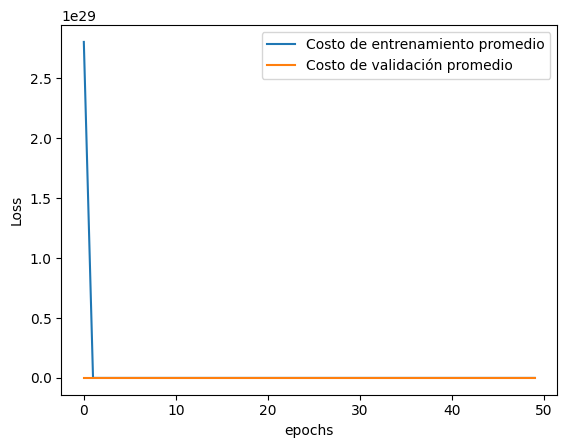

Finished Training


In [17]:
from IPython import display
%matplotlib inline
import time

# TODO: Elige la red que quieres utilizar. Tambien recuerda que puedes modificarla a tu gusto
input_dims = train_dataset.input_dims
output_dims = train_dataset.output_dims
net = net1

# TODO: Define la función de costo a utilizar
cost_function = nn.MSELoss()

# Mandamos los parametros de la red para que los pueda optimizar
optimizer = optim.Rprop(net.parameters(),
                       lr=config['lr'])

loss_plot = PlotLosses()
for epoch in range(config['n_epochs']):  # loop over the dataset multiple times
    train_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # TODO: Realiza el forward pass/ las predicciones actuales para los datos "inputs"
        
        outputs = net(inputs)

        # TODO: Calcula el costo para las predicciones y las etiquetas(labels)
        
        loss =  cost_function(outputs, labels)

        # TODO: Calcula los gradientes para todos los parámetros
        
        loss.backward()

        # TODO: Actualiza los pesos

        optimizer.step()

        # Sumamos el costo del minibatch para calcular el promedio
        train_loss += loss.item()
    
    # Calculamos el costo promedio
    train_loss = train_loss/len(train_loader)
    
    # Por cada 
    val_loss = validation_step(val_loader, net, cost_function)

    # Actualizamos la gráfica de las curvas de entrenamiento
    display.display(plt.gcf())
    display.clear_output(wait=True)
    time.sleep(0.5)
    loss_plot.on_epoch_end(epoch, train_loss, val_loss)
print('Finished Training')

In [18]:
print(f"Costo de entrenamiento: {train_loss}")

Costo de entrenamiento: 1920194880.0


# Conjunto de prueba (Inferencia)
Ahora que la red está entrenada, vamos a predecir los valores para el conjunto de prueba. La siguiente celda utiliza la red que has entrenado anteriormente, calcula las predicciones y genera un csv con las mismas. 

Vamos a ver que equipo logra el menor costo! Ya que tengas las predicciones del conjunto de prueba, súbelas a la [siguiente competencia de Kaggle](https://www.kaggle.com/t/b62cf05f3486cb800056329ff7f44bf1) para que veas el leaderboard.

En esta competencia podrán participar los dos grupos y los equipos ganadores recibirán puntos extra en el examen (:
Puedes subir tus predicciones más de una vez.

Si te interesa encontrar maneras de mejorar la predicción de tu red, puedes consultar la documentación de pytorch sobre [Optimizadores](https://pytorch.org/docs/stable/optim.html).

Puedes intentar, investigar sobre los parámetros adicionales de [Descenso de gradiente Estocástico (SGD)](https://pytorch.org/docs/stable/generated/torch.optim.SGD.html#torch.optim.SGD) o usar un optimizador distinto como [ADAM](https://pytorch.org/docs/stable/generated/torch.optim.Adam.html?highlight=adam#torch.optim.Adam), [ADAGRAD](https://pytorch.org/docs/stable/generated/torch.optim.Adagrad.html#torch.optim.Adagrad) etc.

In [19]:
# Cargamos los datos de prueba y aplicamos el mismo proceso
# Solo que en este caso no hay etiquetas
test_data = read_data(data_dir, "test.csv")
ids = np.array(test_data['Id'], dtype=int)

test_data = test_data.iloc[:, 1:]
test_data = apply_preprocessing(test_data, feat_encoder, obj_cols)
print("Prueba shapes", test_data.shape)

test_data = torch.tensor(test_data, dtype=torch.float)
with torch.inference_mode():
    preds = net(test_data)

preds = preds.detach().cpu().numpy()
submission_df = pd.DataFrame({
    "Id": ids,
    "SalePrice": preds.squeeze()
})
submission_df.to_csv("test_preds.csv", index=False)

Prueba shapes (1459, 79)
